# Florence-2-large Open Food Facts

In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
from off_api import get_images_for_product, get_product_data
import torch

%matplotlib inline

/Users/adelbasli/miniforge3/envs/py314/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
product_id = "0012000130311"

In [3]:
model_id = 'microsoft/Florence-2-large'
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().to(device)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

## Define the prediction function

In [4]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('mps', torch.float16)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].to(device),
        pixel_values=inputs["pixel_values"].to(device),
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

## init image

In [5]:
urls = get_images_for_product(product_id)
product_data = get_product_data(product_id)
url = urls[0]
product_title = product_data['title']
image = Image.open(requests.get(url, stream=True).raw)

Found image IDs: 1, 10, 11, 12, 13, 2, 3, 4, 5, 6, 7, 8, 9


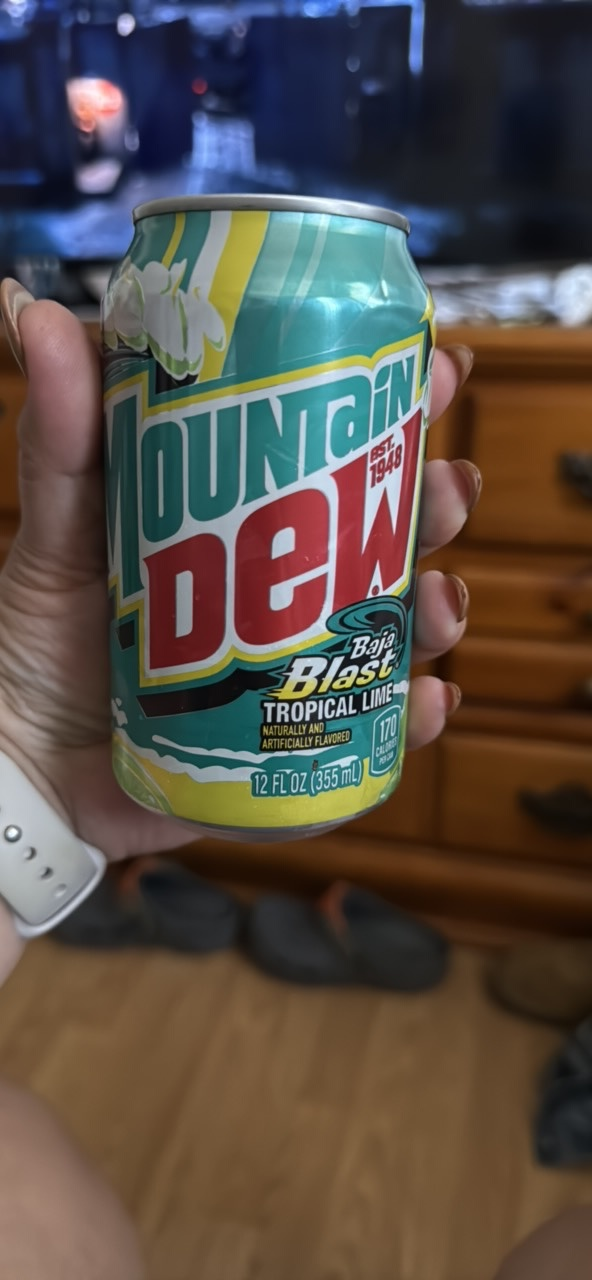

In [6]:
image

### Caption

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def plot_bbox(image, data):
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

### Phrase Grounding
Phrase grounding results format:
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [8]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="product_title")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[97.97599792480469, 191.36000061035156, 438.3760070800781, 842.8800048828125]], 'labels': ['product_title']}}


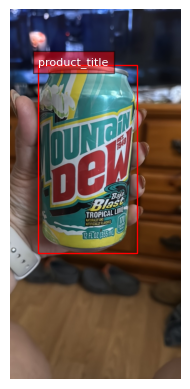

In [9]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

In [10]:
# Crop the image within the bounding box

def extract_images_from_boxes(image, results, task_prompt):
    """
    Extract cropped images based on bounding boxes from model results.

    Args:
        image: PIL Image or path to image
        results: Model output containing bounding boxes
        task_prompt: The task prompt used

    Returns:
        List of cropped images
    """
    if isinstance(image, str):
        image = Image.open(image)

    cropped_images = []

    # Access results under the task_prompt key
    if task_prompt in results:
        task_results = results[task_prompt]
        bboxes = task_results.get('bboxes', [])
        labels = task_results.get('labels', [])

        for i, bbox in enumerate(bboxes):
            x1, y1, x2, y2 = bbox

            # Convert to integers
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            # Crop image
            cropped = image.crop((x1, y1, x2, y2))
            cropped_images.append(cropped)

            # Save with label
            label = labels[i] if i < len(labels) else f"crop_{i}"
            cropped.save(f'images/{label.replace(" ", "_")}.png')

    return cropped_images

In [11]:
# Usage
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="Mountain Dew Baja Blast Tropical Lime")
print(results)

cropped_images = extract_images_from_boxes(image, results, task_prompt)
print(f"Extracted {len(cropped_images)} images")

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[97.38400268554688, 191.36000061035156, 438.968017578125, 844.1599731445312], [97.38400268554688, 191.36000061035156, 438.3760070800781, 844.1599731445312]], 'labels': ['Mountain Dew Baja Blast', 'Blast Tropical Lime']}}
Extracted 2 images
